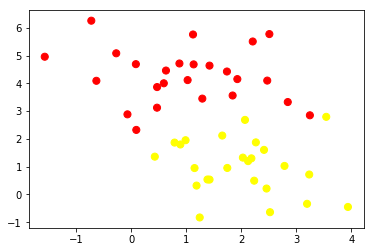

Starting computations...


In [ ]:
import numpy as np
from scipy.optimize import minimize, LinearConstraint, BFGS
from matplotlib import pyplot as plt
from sklearn.datasets.samples_generator import make_blobs, make_moons

# write here the function you are going to optimize
# note that we are using the optimizer which minimizes the function, so you need to account for this
# returns value of the function calculated based on parameters
"""unfold parameters description below"""


# alphas - 1D array
# y - labels
# x - data
# kernel - callable, defines kernel function to use
def function_to_optimize(alphas, y, x, kernel):
    sum, m = 0, len(alphas)
    for i in range(m):
        for j in range(m):
            sum += alphas[i] * alphas[j] * y[i] * y[j] * kernel(x[i], x[j])
    return -(np.sum(alphas) - 0.5 * sum)


# linear kernel <x,z>
# returns scalar - output of the kernel
# x, z - vectors / matrices
def linear_kernel(x, z):
    return x.T.dot(z)


# polynomial kernel (<x,z> + 1)^3 with degree = 3 and c = 1
# returns scalar - output of the kernel
# x, z - vectors / ndarrays
def polynomial_kernel(x, z):
    return (x.T.dot(z) + 1) ** 3


# returns array of indices of all support vectors, i.e. those for which alpha > 0
# instead of zero we are using some threshold to account for roundoff errors
# alphas - array of solutions
# thresh - threshold
def find_support_vector_inds(alphas, thresh):
    res=[]
    for i in range (len(alphas.T)):
        if alphas[i] > thresh:
            res.append(i)
    return np.array(res)


# calculates w and b after alphas are found. w is calculated only if we are using linear kernel
# w is a vector, b is a scalar
# for calculating b use this formula: b = - (wx_pos + wx_neg)/2
# x_pos and x_neg are positive and negative support vectors lying *exactly* on the margin
# Recall that if sample is on correct side, then alpha = 0, if it's exactly on the margin, then 0 < alpha < C,
# if it's on wrong side, alpha = C. So, chose any of those for which 0 < alpha < C, accounting for roundoff errors (!)
"""unfold parameters description below"""


# alphas - array of solutions
# y - labels
# x - data
# sv_inds - indices of support vectors
# kernel - callable, defines kernel function to use
# thresh - threshold
# C - constant
def find_w_b(alphas, y, x, sv_inds, kernel, thresh, C):
    w, b = None, 0
    if kernel == linear_kernel:
        w = 0
        for i in sv_inds:
            w += np.dot(alphas[i] * y[i], x[i])
        sv_index = sv_inds[0]
        for i in sv_inds:
            if 0 < alphas[i] + thresh < C:
                sv_index = i
                break
        b = y[sv_index] - np.dot(w, x[sv_index])
    else:
        sv_index = -1
        for i in sv_inds:
            if 0 < alphas[i] + thresh < C:
                sv_index = i
                break
        sum_of_w_fi_x = 0
        for i in sv_inds:
            sum_of_w_fi_x += alphas[i] * y[i] * kernel(x[i], x[sv_index])
        b = y[sv_index] - sum_of_w_fi_x
    return w, b

    # make predictions for x_test
    # returns array of predictions (1 or -1)
    """unfold parameters description below"""

    # alphas - array of solutions
    # y - labels
    # x - data
    # x_test - data for which predictions should be made
    # b - calculated b
    # sv_inds - indices of support vectors
    # kernel - callable, defines kernel function to use
def predict(alphas, y, x, x_test, b, sv_inds, kernel):
    predictions, m = np.zeros(shape=(len(x_test))), len(x_test)
    for i in range(m):
        for j in sv_inds:
            predictions[i] += alphas[j] * y[j] * kernel(x_test[i], x[j])
    predictions = np.sign(predictions + b)
    return predictions

# this is the main function which brings it all together
# examine it to understand what's happening in each line
# you only need to finish two lines of code here, describing the constraints
# don't change anything else (!)
def minimize_and_plot(X, Y, kernel, C, thresh):
    n = len(Y)
    # arguments to pass to minimize function
    args = (Y, X, kernel)

    # define the constraints (page 20) as instances of scipy.optimize.LinearConstraint
    # constraints each alpha to be from 0 to C
    alpha_constr = LinearConstraint(np.identity(n), 0, C)
    # constraints sum of (alpha * y)
    alpha_y_constr = LinearConstraint(Y, 0, 0)

    print("Starting computations...")
    # minimization. we are using ready QP solver 'trust-constr'
    result = minimize(fun=function_to_optimize, method='trust-constr', x0=np.empty(shape=(n,)), jac='2-point',
                        hess=BFGS(exception_strategy='skip_update'), constraints= [alpha_constr, alpha_y_constr],
                        args=args)
    # prints the results. If status==0, then the optimizer failed to find the optimal value
    print("status:", result.status)
    print("message:", result.message)

    alphas = result.x
    # indexes of support vectors
    sv_inds = find_support_vector_inds(alphas, thresh)
    print("alphas of support vectors:", '\n', alphas[sv_inds])

    w, b = find_w_b(alphas, Y, X, sv_inds, kernel, thresh, C)

    # create a mesh to plot points and predictions
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xrange, yrange = np.meshgrid(np.arange(x_min, x_max, 0.02),
                                    np.arange(y_min, y_max, 0.02))
    # form a grid by taking each point point from x and y range
    grid = np.c_[xrange.ravel(), yrange.ravel()]
    grid = grid.astype(float)
    # make predictions for each point of the grid
    grid_predictions = predict(alphas, Y, X, grid, b, sv_inds, kernel)
    grid_predictions = grid_predictions.reshape(xrange.shape)

    # plot color grid points according to the prediction made for each point
    plt.contourf(xrange, yrange, grid_predictions, cmap='copper', alpha=0.8)
    # plot initial data points
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap='autumn')
    # plot support vectors
    plt.scatter(X[sv_inds, 0], X[sv_inds, 1], s=3, c="black")

    if w is not None:  # print lines on which support vectors should reside
        x_plot = np.linspace(x_min, x_max - 0.02, 1000)
        y_plot_1 = (- w[0] * x_plot - b + 1) / w[1]
        y_plot_2 = (- w[0] * x_plot - b - 1) / w[1]
        plt.plot(x_plot, y_plot_1)
        plt.plot(x_plot, y_plot_2)

    plt.title('SVM Results ' + kernel.__name__)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

# here we assign values for constants
# you can change them when you are testing your solution but when submitting leave it in the original state
n_samples = 50
C_const = 100
threshold = 1e-3

# generating (almost) linearly separable data, replacing 0 labels with -1
X_blob, Y_blob = make_blobs(n_samples=n_samples, centers=2, random_state=0, cluster_std=1.00)
Y_blob[Y_blob == 0] = -1
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=Y_blob, s=50, cmap='autumn')
plt.show()
minimize_and_plot(X_blob, Y_blob, linear_kernel, C_const, threshold)  # svm with linear kernel
minimize_and_plot(X_blob, Y_blob, polynomial_kernel, C_const, threshold)  # svm with polynomial kernel

# generating moon-shaped data, replacing 0 labels with -1
X_moon, Y_moon = make_moons(n_samples=n_samples, shuffle=False, noise=0.10, random_state=0)
Y_moon[Y_moon == 0] = -1
plt.scatter(X_moon[:, 0], X_moon[:, 1], c=Y_moon, s=50, cmap='autumn')
plt.show()
minimize_and_plot(X_moon, Y_moon, linear_kernel, C_const, threshold)  # svm with linear kernel
minimize_and_plot(X_moon, Y_moon, polynomial_kernel, C_const, threshold)  # svm with polynomial kernel
